In [1]:
## goal:
## get something working here... with the heavily reduced image sizes
## then get it into ec2


## TODOS: (just for this section)
### SETUP for dice coefficient --> what will the cost function be here?
### SETUP run length encoding?
### SETUP image rescaler? if train on scaled images then need to rescale output then get run length encoded values


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import imread
from glob import glob
from os.path import basename
import datetime
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss
from utilities import rle_encode

Using Theano backend.


In [3]:
a_mask = imread('data/train_scaled/10_1_mask.png')
a = imread('data/train_scaled/10_1.png')

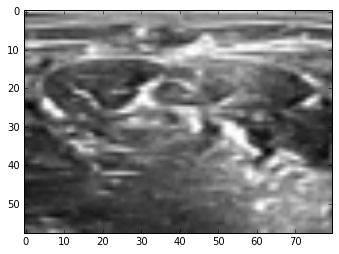

In [4]:
plt.imshow(a, cmap=plt.cm.gray)

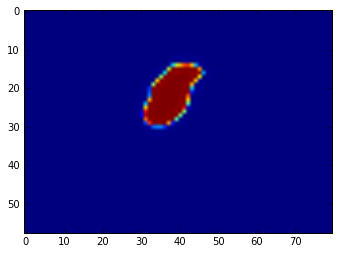

In [5]:
plt.imshow(a_mask)

## load and preprocess train data

In [6]:
## read training data

## code from https://www.kaggle.com/zfturbo/ultrasound-nerve-segmentation/keras-is-there-any-nerve/code
## author -- zfturbo

X_train = []
X_train_id = []
mask_train = []
files = glob('data/train_scaled/*[0-9].png')
for file in files:
    file_basename = basename(file)
    X_train.append(imread(file))
    image_id = file_basename[:-4]
    X_train_id.append(image_id)
    mask_file = 'data/train_scaled/' + image_id + '_mask.png'
    mask_train.append(imread(mask_file))
    
nrows, ncols = X_train[0].shape
train_data = np.array(X_train, dtype=np.uint8)
train_target = np.array(mask_train, dtype=np.uint8)
train_data = train_data.reshape(train_data.shape[0], 1, nrows, ncols)

train_target = (train_target != 0).astype(np.uint8)
train_data = train_data.astype('float32')
train_data /= 255
print('Train shape:', train_data.shape)
print(train_data.shape[0], 'train samples')

Train shape: (5635, 1, 58, 80)
5635 train samples


In [7]:
## for classifying if the mask has any values

train_target = np_utils.to_categorical(train_target, 2)

## load test and preprocess data

In [8]:
files = glob('data/test_scaled/*.png')
X_test = []
X_test_id = []
for file in files:
    file_basename = basename(file)
    img = imread(file)
    X_test.append(img)
    X_test_id.append(file_basename[:-4])
test_data = np.array(X_test, dtype=np.uint8)
test_data = test_data.reshape(test_data.shape[0], 1, nrows, ncols)
test_data = test_data.astype('float32')
test_data /= 255
print('Test shape:', test_data.shape)
print(test_data.shape[0], 'test samples')

Test shape: (5508, 1, 58, 80)
5508 test samples


In [9]:
train_data[0].shape

(1, 58, 80)

## model specification

In [10]:
## try some model??
def create_model(nrows, ncols):
    model = Sequential()
    model.add(Convolution2D(4, 3, 3, border_mode='same', init='he_normal',
                            input_shape=(1, nrows, ncols)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))

    model.add(Convolution2D(8, 3, 3, border_mode='same', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(2))
    model.add(Activation('softmax'))

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model

In [11]:
batch_size = 32
nb_epoch = 50
random_state = 51
n_folds = 10

## train model

In [12]:
kf = KFold(len(train_data), n_folds=n_folds, shuffle=True, random_state=random_state)
num_fold = 0
sum_score = 0
yfull_train = dict()
yfull_test = []
for train_index, test_index in kf:
    model = create_model(nrows, ncols)
    X_train, X_valid = train_data[train_index], train_data[test_index]
    Y_train, Y_valid = train_target[train_index], train_target[test_index]

    num_fold += 1
    print('Start KFold number {} from {}'.format(num_fold, n_folds))
    print('Split train: ', len(X_train), len(Y_train))
    print('Split valid: ', len(X_valid), len(Y_valid))

    callbacks = [
            EarlyStopping(monitor='val_loss', patience=2, verbose=0),
        ]
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              shuffle=True, verbose=2, validation_data=(X_valid, Y_valid),
              callbacks=callbacks)

    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)
    score = log_loss(Y_valid, predictions_valid)
    print('Score log_loss: ', score)
    
    # Store valid predictions
    for i in range(len(test_index)):
        yfull_train[test_index[i]] = predictions_valid[i]

    # Store test predictions
    test_prediction = model.predict(test_data, batch_size=batch_size, verbose=2)
    yfull_test.append(test_prediction)

Start KFold number 1 from 10
Split train:  5071 5071
Split valid:  564 564
Train on 5071 samples, validate on 564 samples
Epoch 1/50
5s - loss: 0.8762 - val_loss: 0.8412
Epoch 2/50
5s - loss: 0.8333 - val_loss: 0.8270
Epoch 3/50
5s - loss: 0.8211 - val_loss: 0.8246
Epoch 4/50
5s - loss: 0.8086 - val_loss: 0.8119
Epoch 5/50
5s - loss: 0.8023 - val_loss: 0.8057
Epoch 6/50
5s - loss: 0.7970 - val_loss: 0.8070
Epoch 7/50
5s - loss: 0.7942 - val_loss: 0.7991
Epoch 8/50
5s - loss: 0.7909 - val_loss: 0.8025
Epoch 9/50
5s - loss: 0.7874 - val_loss: 0.7939
Epoch 10/50
5s - loss: 0.7831 - val_loss: 0.7938
Epoch 11/50
5s - loss: 0.7817 - val_loss: 0.7990
Epoch 12/50
5s - loss: 0.7804 - val_loss: 0.7914
Epoch 13/50
5s - loss: 0.7782 - val_loss: 0.7911
Epoch 14/50
5s - loss: 0.7772 - val_loss: 0.7918
Epoch 15/50
5s - loss: 0.7753 - val_loss: 0.7935
Epoch 16/50
5s - loss: 0.7733 - val_loss: 0.7929
564/564 [==============================] - 0s     
Score log_loss:  0.792895019788
Start KFold number 2

In [13]:
len(yfull_train)

5635

In [14]:
## need to rewrite this...

def getPredScorePercent(train_target, train_id, predictions_valid):
    perc = 0
    for i in range(len(train_target)):
        pred = 1
        if predictions_valid[i][0] > 0.5:
            pred = 0
        real = 1
        if train_target[i][0] > 0.5:
            real = 0
        if real == pred:
            perc += 1
    perc /= len(train_target)
    return perc




predictions_valid = [yfull_train[k] for k in yfull_train.keys()]
score = log_loss(train_target, predictions_valid)
print("Log_loss train independent avg: ", score)

print('Final log_loss: {}, rows: {} cols: {} nfolds: {} epoch: {}'.format(score, nrows, ncols, n_folds, nb_epoch))
perc = getPredScorePercent(train_target, X_train_id, predictions_valid)
print('Percent success: {}'.format(perc))

Log_loss train independent avg:  0.785018804578
Final log_loss: 0.785018804577818, rows: 58 cols: 80 nfolds: 10 epoch: 50
Percent success: 0.9304347826086956


In [15]:
yfull_test[0].shape

(5508, 2)

In [16]:
yfull_test[1].shape

(5508, 2)

In [17]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return [ix[1] for ix in a]

test_res = merge_several_folds_mean(yfull_test, n_folds)
print(len(test_res))
print(test_res[0])

5508
0.400962


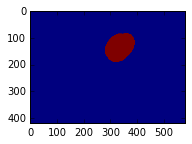

In [18]:
## computed by average_mask.py
avg_mask = pd.read_csv('average_mask.csv').values
avg_mask_rle = rle_encode(avg_mask)  ## get run length encoding of this

## average mask
plt.figure(figsize=(4,2))
plt.imshow(avg_mask)
plt.show()

In [19]:
submission = pd.DataFrame({'img':X_test_id})
submission['pixels'] = ''
submission['predictions'] = test_res
submission.loc[submission.predictions > 0.5, 'pixels'] = avg_mask_rle
submission = submission.drop('predictions', axis=1)

In [20]:
submission.sort_values('img').to_csv('data/submissions/submission_test_2.csv', index=False)